# Imports

In [1]:
import sys, os

import s3fs
import xarray as xr
import pandas as pd

import progressbar

import warnings

from math import sqrt
from joblib import Parallel, delayed

from scipy import integrate
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
from string import ascii_lowercase
from pylab import text

import imageio

sys.path.append('../utilities')
import GrIS_committedSLR_calibration_utilities as utils
import mascons

import boto3

import pickle


import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# Setup

In [2]:
start_year = 2007.
end_year = 2015.

grid_size = 50000.
grid_extent = np.array([-720500.0, 960500.0, -3450500.0, -569500.0])

x_centers = np.arange(grid_extent[0]+grid_size/2, grid_extent[1]-grid_size/2, grid_size)
y_centers = np.arange(grid_extent[2]+grid_size/2, grid_extent[3]-grid_size/2, grid_size)

# Compare ad-hoc multipliers for velocity change
run_names = ['velocity_sigmamodx25', 'velocity_sigmamodx50', 'velocity_sigmamodx75']
posterior_pdf_plot_output_filename = 'gmsl_posteriors_velocity.pdf'

# Compare ad-hoc multipliers for thickness change
run_names = ['thickness_sigmamodx50', 'thickness_sigmamodx100', 'thickness_sigmamodx150']
posterior_pdf_plot_output_filename = 'gmsl_posteriors_thickness.pdf'

# Compare ad-hoc multipliers for mass change
run_names = ['mass_sigmamodx2', 'mass_sigmamodx4', 'mass_sigmamodx8']
posterior_pdf_plot_output_filename = 'gmsl_posteriors_mass.pdf'

# Compare across observation types
run_names = ['velocity_sigmamodx75', 'thickness_sigmamodx150', 'mass_sigmamodx8']
posterior_pdf_plot_output_filename = 'gmsl_posteriors_all.pdf'


### Total MAF / GMSL

In [3]:
# Load total MAF / GMSL
maf_cmmtt = dict()
maf_ctrl = dict()
gmsl_change_2100 = dict()
gmsl_anomaly_change_2100 = dict()

s3 = s3fs.S3FileSystem(anon=False)
maf_files = s3.glob('dh-gapc/GrIS_committed_SLR/netcdfs/MAF/*cmmtt*MAF.nc')

ensembleIDs = list()
for iFile, maf_file in enumerate(maf_files):
    ensembleID = os.path.basename(maf_file).split('.')[3]
    ensembleIDs.append(ensembleID)
    
    # Read cmmtt MAF netcdf
    with s3.open(maf_file, 'rb') as f:
        maf_ds = xr.open_dataset(f, engine='h5netcdf')

        limnsw = maf_ds['limnsw'].data
        maf_cmmtt[ensembleID] = limnsw
    
    
    # Read ctrl MAF netcdf
    maf_file = maf_file.replace('cmmtt','ctrl')
    
    with s3.open(maf_file, 'rb') as f:
        maf_ds = xr.open_dataset(f, engine='h5netcdf')

        limnsw = maf_ds['limnsw'].data
        maf_ctrl[ensembleID] = limnsw
    
    
    maf_anomaly = maf_cmmtt[ensembleID] - maf_ctrl[ensembleID]
    maf_anomaly_change_2100 = maf_anomaly[-1] - maf_anomaly[1]
    gmsl_anomaly_change_2100[ensembleID] = -(maf_anomaly_change_2100/1e12)/361.8
    
    maf_change_2100 = maf_cmmtt[ensembleID][-1] - maf_cmmtt[ensembleID][0]
    gmsl_change_2100[ensembleID] = -(maf_change_2100/1e12)/361.8


### LHS variables

In [4]:
# Load the LHS variables

# Load the ensemble IDs
df = pd.read_csv('s3://dh-gapc/GrIS_committed_SLR/LatinHypercubeSampling/IDs.txt', sep=' ', header=None)

# Select just the ensembleIDs with data
rows = list()
for iFile, maf_file in enumerate(maf_files):
    ensembleID = os.path.basename(maf_file).split('.')[3]
    rows.append(df.index[df[0] == ensembleID].to_list()[0])
rows = np.array(rows)

# Load the LHS variables
df = pd.read_csv('s3://dh-gapc/GrIS_committed_SLR/LatinHypercubeSampling/ensemble-128-4p-noID.tab', sep=' ')
cols = df.columns

lhs_vars = dict()
for icol, col in enumerate(cols):
    lhs_vars[col] = df.to_numpy()[rows,icol]

    
# LHS v1: friction
# read in LHS scalar and convert to the multiplication factor
# so that 0.5 is the default simulation (from the inversion)
# basal friction
# [0 1] --> [-50% +50%]
# [0 1] --> [0.5 1.5]
# 
# lhsv1 = 0.5 + lhs.fric(i)*1.0;
#
# Perturb basal friction coefficient
# pert_fric = md.friction.coefficient*lhsv1;
lhs_vars['V1'] = -50. + lhs_vars['V1']*100.

# LHS v2: viscosity
# read in LHS scalar
# [0 1] --> [-10K 10K]
#
# lhsv2 = -10 + lhs.visc(i)*20;
#
# Perturb temperature by adding anomaly (in degrees K)
# pert_temp = md.initialization.temperature+lhsv2;
#
# Ensure that temperature not higher than melting point
# pert_temp(pert_temp > md.materials.meltingpoint) = md.materials.meltingpoint;
# Perturb rheology_B (rigidity)
# pert_visc = cuffey(pert_temp);

lhs_vars['V2'] = -10. + lhs_vars['V2']*20.

# LHS v3: shift in mean smb
#       up to ~+/- 127.5 Gt averaged over entire ice sheet (in m/yr ice)
#       This is +30%/-30% of 1960-89 mean (or approximately 1 sigma)
# 
# Read in LHS scalar and convert to +/-0.3
# [0 1] --> [-30% +30%] (1 sigma of 1960-89 period)
# [0 1] --> [-0.3 0.3]
# lhsv3 = -0.3 + lhs.smb1(i)*0.6;

lhs_vars['V3'] = -30. + lhs_vars['V3']*60.;

# LHS v4: varying strength of seasonal cycle
#       from mean seasonal cycle of the 1960-1989 period
#       mean cycle = 1
#       varies between 0 (no cycle) and 2 (double amplitude)
# 
# lhsv4 = lhs.smb2(i)*2;

lhs_vars['V4'] = lhs_vars['V4']*200.;


### Dynamic dh from SERAC

In [5]:
# Read dynamic dh from SERAC
dh_dyn_obs = utils.read_SERAC_obs('SERAC/SERACAnnualRates2021JanIGSPres.csv')

# select obs
dh_dyn_obs_selected = utils.select_dh_obs(dh_dyn_obs, startYear=start_year, endYear=end_year, dhThresholdMax=np.nan)
print('selected number of obs: {:8d}'.format(len(dh_dyn_obs_selected)))


total    number of obs:    53224
selected number of obs:    16136


### Velocity observations

In [6]:
_, _, vel_year1, _, _, vel_error_year1, vel_year1_transform, vel_year1_bounds = utils.read_vel_error_tifs(start_year)
_, _, vel_year2, _, _, vel_error_year2, vel_year2_transform, vel_year2_bounds = utils.read_vel_error_tifs(end_year)

vel_year1_obs_grid = utils.grid_vel_obs(vel_year1, vel_year1_transform, x_centers, y_centers, grid_size, grid_size)
vel_error_year1_obs_grid = utils.grid_vel_obs(vel_error_year1, vel_year1_transform, x_centers, y_centers, grid_size, grid_size)
vel_year2_obs_grid = utils.grid_vel_obs(vel_year2, vel_year2_transform, x_centers, y_centers, grid_size, grid_size)
vel_error_year2_obs_grid = utils.grid_vel_obs(vel_error_year2, vel_year2_transform, x_centers, y_centers, grid_size, grid_size)

dv_obs_grid = vel_year2_obs_grid - vel_year1_obs_grid
ev_obs_grid = np.sqrt(vel_error_year1_obs_grid**2 + vel_error_year2_obs_grid**2)


# Bayesian calibration

In [7]:
# Select the weights
w_j_list = list()
for run_name in run_names:
    print(run_name)
    p = pickle.load(open('results/' + run_name + '/weights.p', 'rb'))
    w_j = p['w_j']
    w_j_list.append(w_j)
    
    with open('results/' + run_name + '/description.txt', 'r') as f: description = f.read()
    print(description)
    print('')
    
colors = list()
colors.append(plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
colors.append(plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
colors.append('k')

if len(run_names) > 3:
    import matplotlib
    from matplotlib import cm
    norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
    
    for i in range(3,len(run_names)):
        colors.append(matplotlib.colors.to_hex(cm.tab10(norm(i))))


velocity_sigmamodx75
start_year = 2007; end_year = 2015; grid_size =    50000; residual_sigma_multiplier =    75;

thickness_sigmamodx150
start_year = 2007; end_year = 2015; grid_size =    50000; dh_mod_obs_sigma_multiplier =   150; dhThresholdMax = nan


mass_sigmamodx8
start_year = 2007; end_year = 2015; grid_size = N/A; residual_sigma_multiplier = 8;



          :    MAP    p05    p50    p95   P(>  50)  P(> 100)
prior     :   -3.4  -60.3   26.6  213.3     38.8%     23.0%
velocity  :   24.5  -23.9   20.4   64.5     14.2%      0.1%
thickness :  -10.3  -51.0   -6.4   51.2      5.3%      0.1%
mass      :   35.1  -14.7   33.8   77.8     28.1%      0.6%


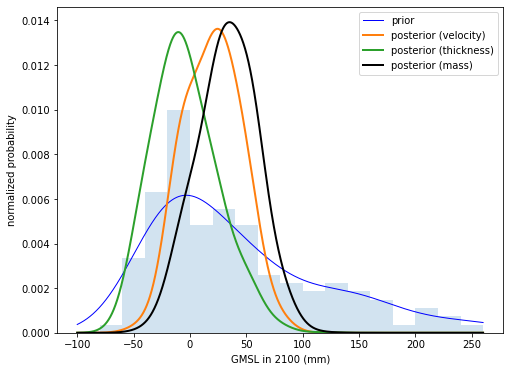

In [8]:
# Select thesholds
gmsl_thresholds = [50, 100] # mm of GMSL rise in 2100


gmsl_change_2100_values = list(gmsl_change_2100.values())

bins = np.arange(-100,280,20)

print('          :    MAP    p05    p50    p95   P(>{:4.0f})  P(>{:4.0f})'.format(gmsl_thresholds[0], gmsl_thresholds[1]))
fig, ax = plt.subplots(figsize=(8,6))

### Prior
# estimated density
_ = ax.hist(gmsl_change_2100_values, density=True, alpha=0.2, bins=bins)
x_kde, gmsl_prior, gmsl_posterior = utils.gmsl_prior_posterior(gmsl_change_2100_values, w_j_list[0], xmin=bins[0], xmax=bins[-1])
ax.plot(x_kde, gmsl_prior, label='prior', color='b', linewidth=1.)
# stats and thresholds
MAP, pcnt05, pcnt50, pcnt95, threshold_probabilities = utils.stats_from_kde(x_kde, gmsl_prior, thresholds=gmsl_thresholds)
print('{:10s}: {:6.1f} {:6.1f} {:6.1f} {:6.1f}'.format('prior', MAP, pcnt05, pcnt50, pcnt95), end='')
# thresholds
for i, gmsl_threshold in enumerate(gmsl_thresholds):
    print('   {:6.1f}%'.format(threshold_probabilities[i]), end='')

print('')


#ax.set_xlim(0,.1)

### Posteriors
for i, (run_name, w_j) in enumerate(zip(run_names, w_j_list)):
    run_name_short = run_name.split('_')[0]

    # estimated density
    x_kde, gmsl_prior, gmsl_posterior = utils.gmsl_prior_posterior(gmsl_change_2100_values, w_j, xmin=bins[0], xmax=bins[-1])
    ax.plot(x_kde, gmsl_posterior, colors[i], label='posterior (' + run_name_short + ')', linewidth=2.)

    # stats
    MAP, pcnt05, pcnt50, pcnt95, threshold_probabilities = utils.stats_from_kde(x_kde, gmsl_posterior, thresholds=gmsl_thresholds)
    
    # thresholds
    print('{:10s}: {:6.1f} {:6.1f} {:6.1f} {:6.1f}'.format(run_name_short,  MAP, pcnt05, pcnt50, pcnt95), end='')
    for i, gmsl_threshold in enumerate(gmsl_thresholds):
        print('   {:6.1f}%'.format(threshold_probabilities[i]), end='')

    print('')

plt.legend()
plt.xlabel('GMSL in 2100 (mm)')
plt.ylabel('normalized probability')

plt.savefig('plots/' + posterior_pdf_plot_output_filename, bbox_inches='tight')


## Plot posteriors of parameter and forcing uncertainty

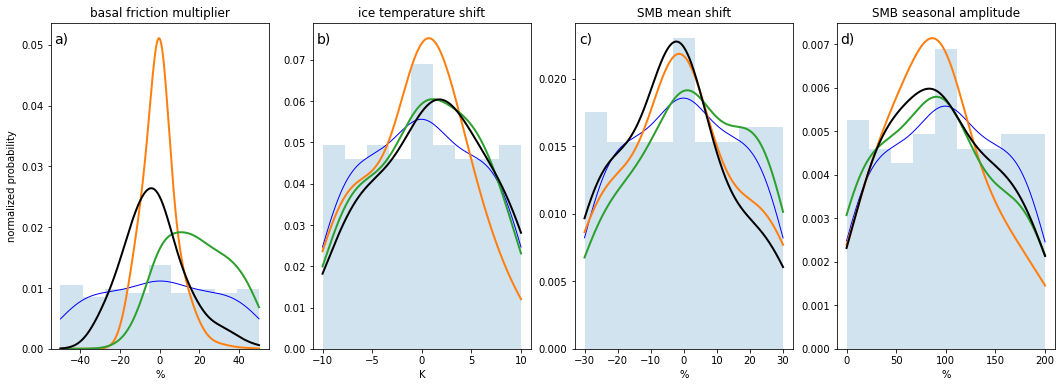

In [9]:
fig, ax = plt.subplots(1,4,figsize=(18,6))

for ivar, var in enumerate(lhs_vars.keys()):
    bins = np.linspace(np.min(lhs_vars[var]), np.max(lhs_vars[var]), 10)
    ax[ivar].hist(lhs_vars[var], density=True, alpha=0.2, bins=bins)
    
for i, w_j in enumerate(w_j_list):
    for ivar, var in enumerate(lhs_vars.keys()):
        bins = np.linspace(np.min(lhs_vars[var]), np.max(lhs_vars[var]), 10)
        x_kde, lhs_var_prior, lhs_var_posterior = utils.gmsl_prior_posterior(lhs_vars[var], w_j, xmin=bins[0], xmax=bins[-1])
        if i == 0:
            ax[ivar].plot(x_kde, lhs_var_prior, label=run_names[i], color='b', linewidth=1.)
        ax[ivar].plot(x_kde, lhs_var_posterior, label=run_names[i], color=colors[i], linewidth=2.)

#ax[0].text(0.1, 0.1, 'a)')
ax[0].set_xlabel('%')
ax[1].set_xlabel('K')
ax[2].set_xlabel('%')
ax[3].set_xlabel('%')
ax[0].set_ylabel('normalized probability')
ax[0].set_title('basal friction multiplier')
ax[1].set_title('ice temperature shift')
ax[2].set_title('SMB mean shift')
ax[3].set_title('SMB seasonal amplitude')

text(0.05, 0.95,'a)',fontsize=14,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[0].transAxes)
text(0.05, 0.95,'b)',fontsize=14,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[1].transAxes)
text(0.05, 0.95,'c)',fontsize=14,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[2].transAxes)
text(0.05, 0.95,'d)',fontsize=14,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[3].transAxes)


plt.savefig('plots/lhs_variables_pdfs.pdf', bbox_inches='tight')


# Plot residuals for highest-weighted ensemble member from each calibration

../utilities/GrIS_committedSLR_calibration_utilities.py:247: RuntimeWarning: Mean of empty slice
  z_mod_grid[row, col] = np.nanmean(z_mod[np.min(idx_row):np.max(idx_row), \


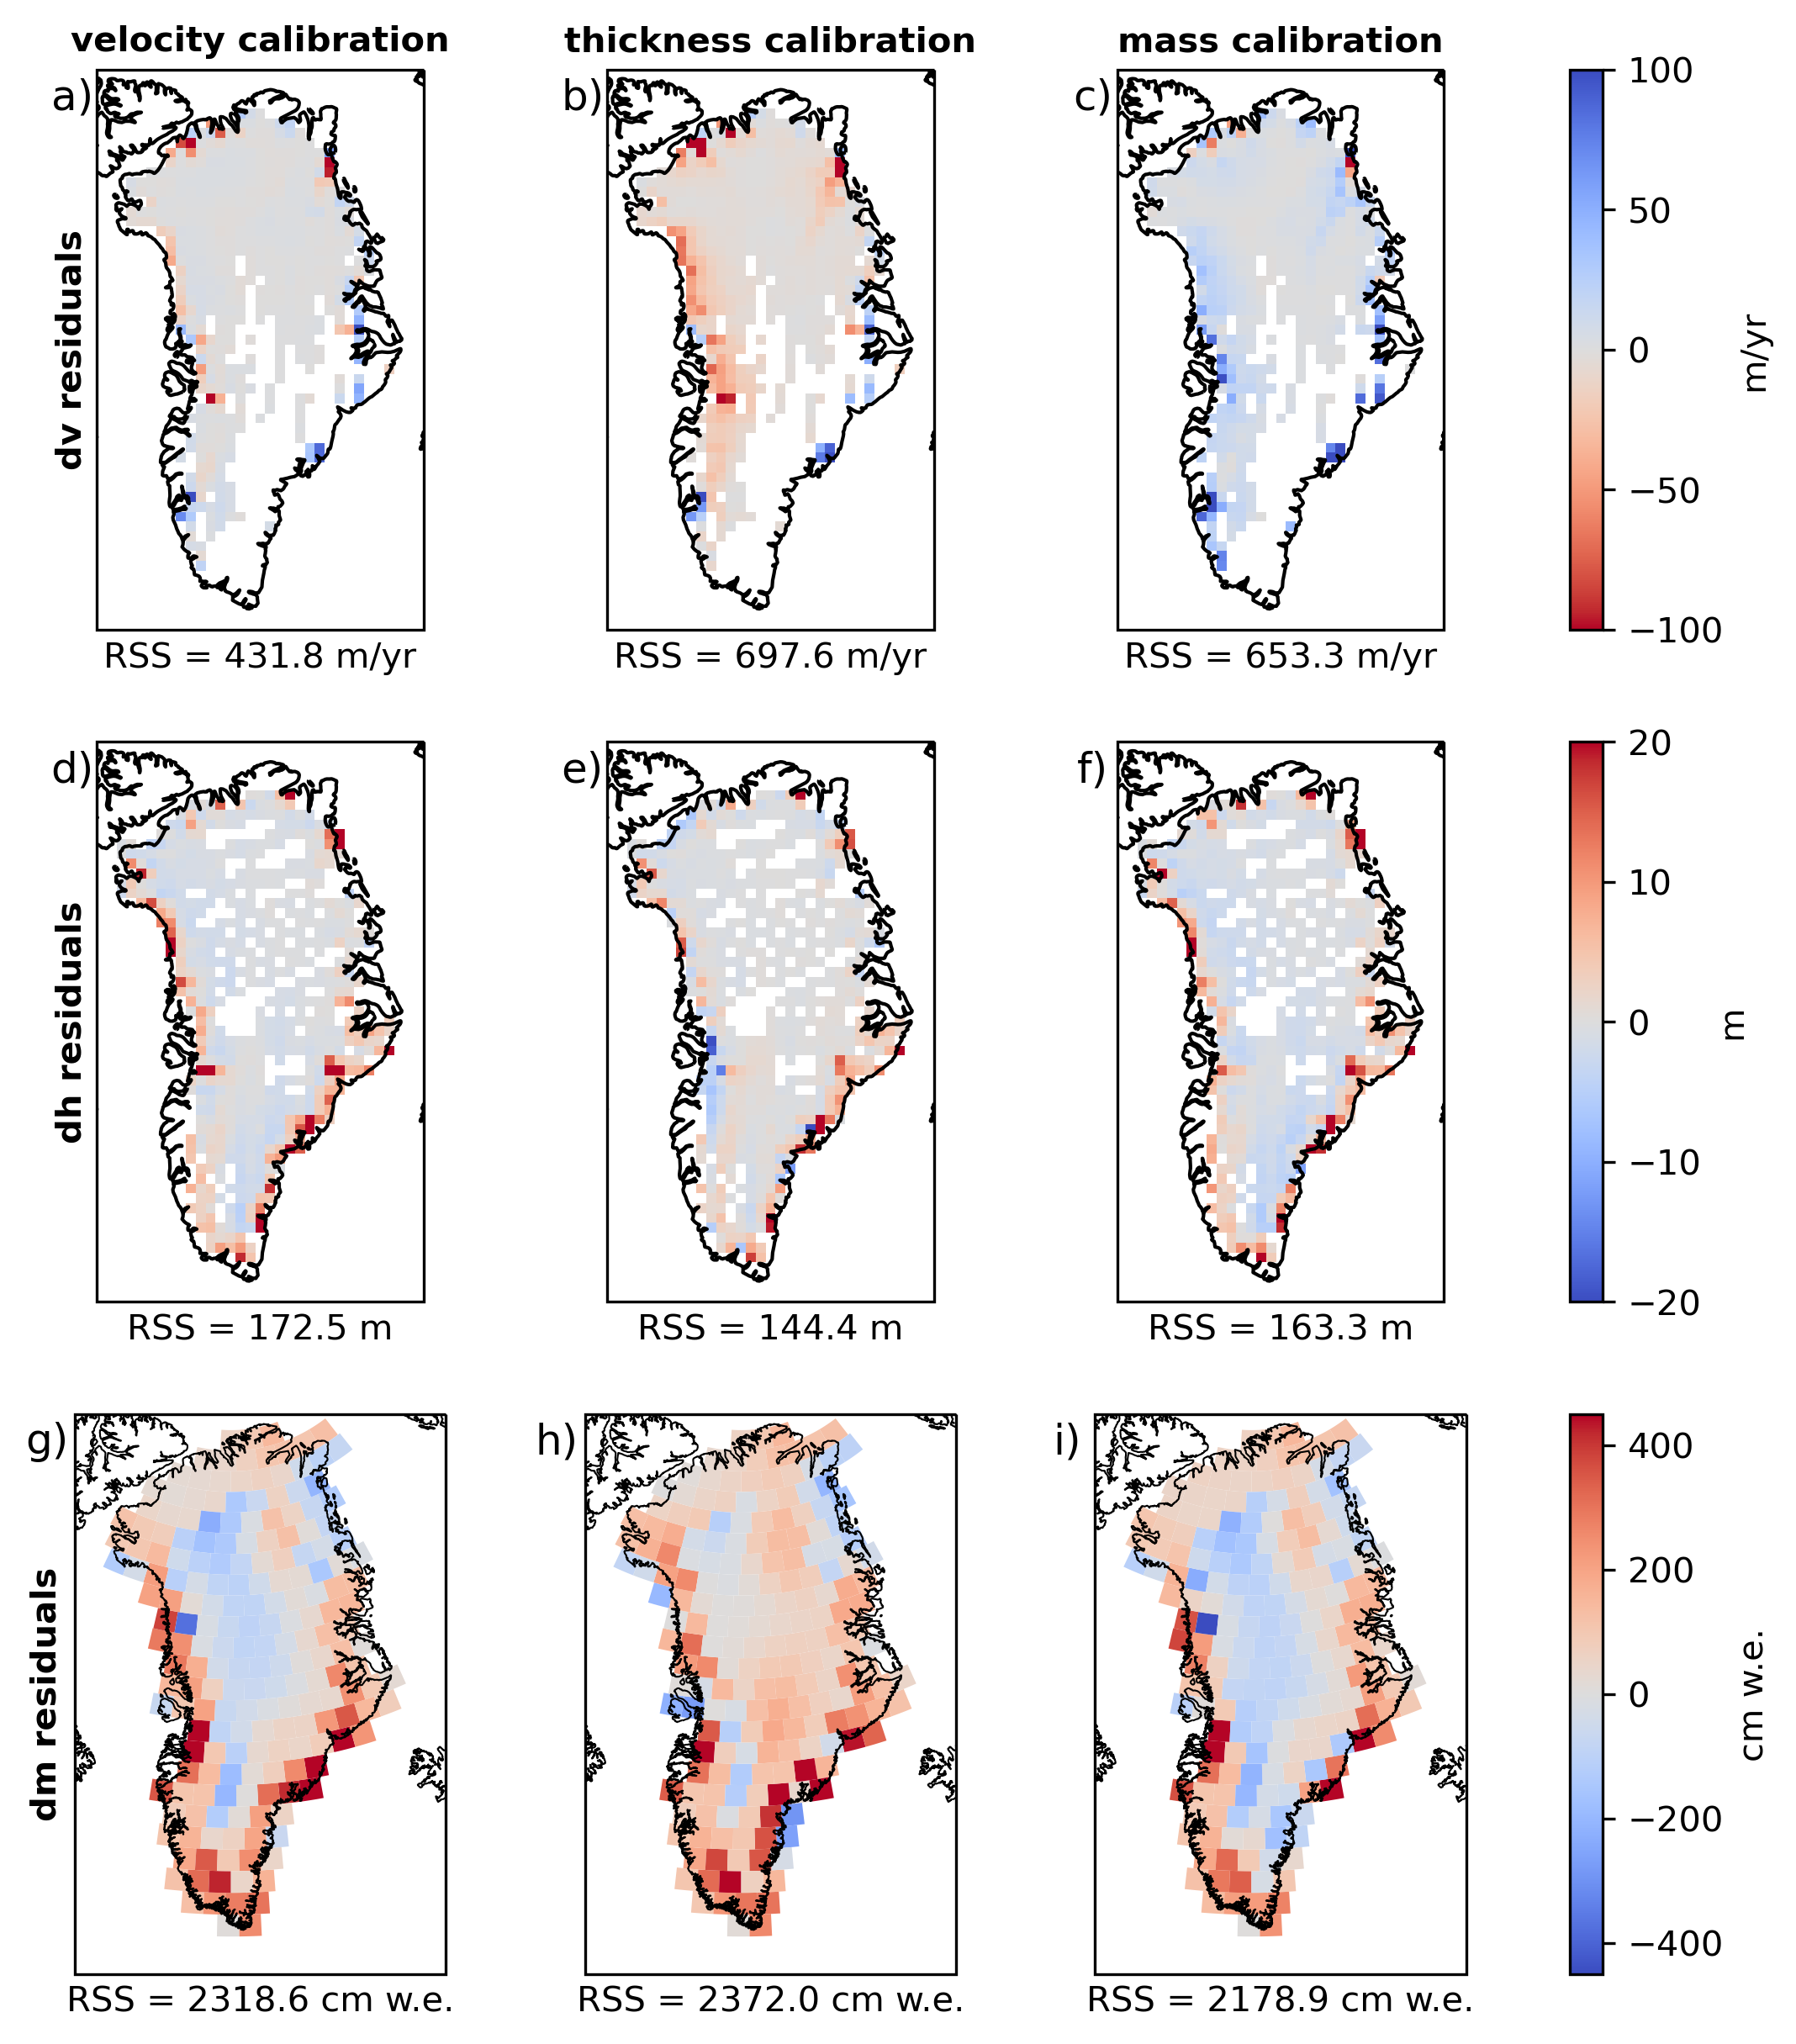

In [10]:
dhdynAnom_file_template = 'dh-gapc/GrIS_committed_SLR/zarr/dhdynAnom/gris.proj.2007-2015.????.dhdynAnom6079.nc.zarr'
dv_file_template = 'dh-gapc/GrIS_committed_SLR/zarr/velocity/gris.proj.2007-2015.????.dv.nc.zarr'

plot_selection = 'highest' # 'highest' | 'second_highest'

## -- Plot setup ------------------------------------------------------- ##
# Set up a grid for plotting dh
grid_size_plot = 50000.
x_centers_plot = np.arange(grid_extent[0]+grid_size_plot/2, grid_extent[1]-grid_size_plot/2, grid_size_plot)
y_centers_plot = np.arange(grid_extent[2]+grid_size_plot/2, grid_extent[3]-grid_size_plot/2, grid_size_plot)

# Grid the dh observations for plotting
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    dh_obs_grid_plot, dh_obs_sigma_grid_plot = utils.grid_obs_dh(\
                                                    x_centers_plot, y_centers_plot, grid_size_plot, grid_size_plot, \
                                                    dh_dyn_obs_selected, startYear=start_year, endYear=end_year)

import cartopy.crs as ccrs
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

fig = plt.figure(figsize=(8, 10), dpi=300)
spec = fig.add_gridspec(3, 4, width_ratios=[1, 1, 1, 0.075])
axs = list()


## -- Velocity residuals --------------------------------------------- ##
for i, w_j in enumerate(w_j_list):
    w_j_sorted_idx = sorted(range(len(w_j)), key=lambda i: w_j[i])
    if plot_selection == 'highest':
        ensembleID = ensembleIDs[w_j_sorted_idx[-1]]
    if plot_selection == 'second_highest':
        ensembleID = ensembleIDs[w_j_sorted_idx[-2]]
        
    mod_name = dv_file_template.replace('????', ensembleID)
    
    dv_mod_grid = utils.grid_mod_dh(mod_name, x_centers, y_centers, grid_size, grid_size, var_name='dv')

    residuals = dv_mod_grid - dv_obs_grid
    ax = fig.add_subplot(spec[0, i], projection=polar_stereographic)
    im = ax.imshow(residuals, extent=[e for e in grid_extent], \
                        cmap='coolwarm_r', vmin=-100, vmax=100, origin='lower', \
                        aspect='equal')
    ax.coastlines()
    axs.append(ax)
        
    residuals_rss = np.sqrt(np.nansum(residuals**2))
    text(0.50, -0.05, 'RSS = {:4.1f} m/yr'.format(residuals_rss),
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes)


cax = fig.add_subplot(spec[0, 3])
axs.append(cax)
cb = fig.colorbar(im, cax=cax, shrink=0.7)
cb.ax.set_ylabel('m/yr')

axs[0].set_ylabel('dv residuals')



## -- Thickness residuals --------------------------------------------- ##
for i, w_j in enumerate(w_j_list):
    w_j_sorted_idx = sorted(range(len(w_j)), key=lambda i: w_j[i])
    if plot_selection == 'highest':
        ensembleID = ensembleIDs[w_j_sorted_idx[-1]]
    if plot_selection == 'second_highest':
        ensembleID = ensembleIDs[w_j_sorted_idx[-2]]
    
    mod_name = dhdynAnom_file_template.replace('????', ensembleID)
    
    dh_mod_grid = utils.grid_mod_dh(mod_name, x_centers_plot, y_centers_plot, grid_size_plot, grid_size_plot)

    residuals = dh_mod_grid - dh_obs_grid_plot
    ax = fig.add_subplot(spec[1, i], projection=polar_stereographic)
    im = ax.imshow(residuals, extent=[e for e in grid_extent], \
                        cmap='coolwarm', vmin=-20, vmax=20, origin='lower', \
                        aspect='equal')
    ax.coastlines()
    axs.append(ax)

    residuals_rss = np.sqrt(np.nansum(residuals**2))
    text(0.50, -0.05, 'RSS = {:4.1f} m'.format(residuals_rss),
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes)

    
cax = fig.add_subplot(spec[1, 3])
axs.append(cax)
cb = fig.colorbar(im, cax=cax, shrink=0.7)
cb.ax.set_ylabel('m')

axs[4].set_ylabel('dh residuals')


## -- Mass residuals --------------------------------------------- ##
# Load high-res trend mascons for GrIS
gsfc = utils.load_gscf_mascons()
gsfc_cmwe_delta = gsfc['cmwe_delta']
gsfc_cmwe_delta_sigma = gsfc['cmwe_delta_sigma']
lat_centers = gsfc['lat_centers']
lon_centers = gsfc['lon_centers']
min_lats = gsfc['min_lats']
max_lats = gsfc['max_lats']
min_lons = gsfc['min_lons']
max_lons = gsfc['max_lons']
areas = gsfc['areas']
labels = gsfc['labels']

vmin = -450
vmax = +450

# ISSM mascons
mc_hat = pd.read_csv('../utilities/ISSMmascons_hat.csv')

for i, w_j in enumerate(w_j_list):
    w_j_sorted_idx = sorted(range(len(w_j)), key=lambda i: w_j[i])
    if plot_selection == 'highest':
        ensembleID = ensembleIDs[w_j_sorted_idx[-1]]
    if plot_selection == 'second_highest':
        ensembleID = ensembleIDs[w_j_sorted_idx[-2]]
    
    cmwe_delta = mc_hat[ensembleID].to_numpy()
    residuals = cmwe_delta - gsfc_cmwe_delta
    
    ax = fig.add_subplot(spec[2, i], projection=polar_stereographic)
    sc = utils.plot_GSFCmascons(lon_centers, lat_centers, residuals, min_lons, max_lons, min_lats, max_lats, \
                                cmap='coolwarm', ax=ax, vmin=vmin, vmax=vmax)
    
    axs.append(ax)
    
    residuals_rss = np.sqrt(np.nansum(residuals**2))
    text(0.50, -0.05, 'RSS = {:4.1f} cm w.e.'.format(residuals_rss),
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes)
    
cax = fig.add_subplot(spec[2, 3])
axs.append(cax)
cb = fig.colorbar(sc, cax=cax, shrink=0.7)
cb.ax.set_ylabel('cm w.e.')


## -- Other plot stuff --------------------------------------------- ##

#axs[8].set_ylabel('dM residuals')
#def numfmt(x, pos): # your custom formatter function: divide by 1000
#    s = '{:.0f}'.format(x / 1000)
#    return s
#for iax in [8, 9, 10]:
#    axs[iax].xaxis.set_visible(True)
#    axs[iax].yaxis.set_visible(True)
#    tick_fmt = tkr.FuncFormatter(numfmt)
#    axs[iax].xaxis.set_major_formatter(tick_fmt)
#    axs[iax].yaxis.set_major_formatter(tick_fmt)
for iax in [0, 1, 2, 4, 5, 6]:
    axs[iax].xaxis.set_visible(False)
    axs[iax].yaxis.set_visible(False)
    
text(0.50, 1.05, 'velocity calibration', weight='bold',
     horizontalalignment='center',
     verticalalignment='center',
     transform = axs[0].transAxes)

text(0.50, 1.05, 'thickness calibration', weight='bold',
     horizontalalignment='center',
     verticalalignment='center',
     transform = axs[1].transAxes)

text(0.50, 1.05, 'mass calibration', weight='bold',
     horizontalalignment='center',
     verticalalignment='center',
     transform = axs[2].transAxes)

text(-0.075, 0.50, 'dv residuals', weight='bold',
     horizontalalignment='center',
     verticalalignment='center',
     transform = axs[0].transAxes, rotation=90)

text(-0.075, 0.50, 'dh residuals', weight='bold',
     horizontalalignment='center',
     verticalalignment='center',
     transform = axs[4].transAxes, rotation=90)

text(-0.075, 0.50, 'dm residuals', weight='bold',
     horizontalalignment='center',
     verticalalignment='center',
     transform = axs[8].transAxes, rotation=90)

for i, iax, in enumerate([0, 1, 2, 4, 5, 6, 8, 9, 10]):
    text(-0.075, 0.95,ascii_lowercase[i]+')',fontsize=12,
         horizontalalignment='center',
         verticalalignment='center',
         transform = axs[iax].transAxes)

# Save figure
if plot_selection == 'highest':
    plt.savefig('plots/heighest_weight_ensemble_member_residuals.pdf', bbox_inches='tight')
elif plot_selection == 'second_highest':
    plt.savefig('plots/second_heighest_weight_ensemble_member_residuals.pdf', bbox_inches='tight')


## Print the highest- and lowest-weighted ensemble IDs and GMSLs in 2100

In [11]:
for i, w_j in enumerate(w_j_list):
    w_j_sorted_idx = sorted(range(len(w_j)), key=lambda i: w_j[i])
    ensembleID = ensembleIDs[w_j_sorted_idx[-1]]
    print('Highest weighted: {:s}: {:+7.2f} mm'.format(ensembleID, gmsl_change_2100[ensembleID]))
    
    w_j_sorted_idx = sorted(range(len(w_j)), key=lambda i: w_j[i])
    ensembleID = ensembleIDs[w_j_sorted_idx[0]]
    print('Lowest weighted:  {:s}: {:+7.2f} mm'.format(ensembleID, gmsl_change_2100[ensembleID]))
    

Highest weighted: A1084:  +25.29 mm
Lowest weighted:  A1072: +275.98 mm
Highest weighted: A1112:  -13.01 mm
Lowest weighted:  A0001: +239.46 mm
Highest weighted: A1070:  +35.36 mm
Lowest weighted:  A0001: +239.46 mm
